# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [37]:
#!gdown 1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf

In [84]:
# your code here
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot 
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, r2_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedShuffleSplit, GridSearchCV


pd.options.mode.copy_on_write = True

In [39]:
df = pd.read_csv('data_adult.csv', delimiter=',')
print(df.shape)

(16280, 14)


In [40]:
print(df)

       age  workclass  fnlwgt     education  education-num  \
0       34  Local-gov  284843       HS-grad              9   
1       40    Private  190290  Some-college             10   
2       36  Local-gov  177858     Bachelors             13   
3       22    Private  184756  Some-college             10   
4       47    Private  149700     Bachelors             13   
...    ...        ...     ...           ...            ...   
16275   25  Local-gov  514716     Bachelors             13   
16276   32    Private  207668     Bachelors             13   
16277   27    Private  104457     Bachelors             13   
16278   59  State-gov  268700       HS-grad              9   
16279   33    Private   59083     Bachelors             13   

           marital-status         occupation   relationship  \
0           Never-married    Farming-fishing  Not-in-family   
1                Divorced              Sales  Not-in-family   
2      Married-civ-spouse     Prof-specialty      Own-child   
3  

In [41]:
print(df.describe())
print(df.info())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  16280.000000  1.628000e+04   16280.000000  16280.000000  16280.000000   
mean      38.635074  1.894594e+05      10.098219   1020.417752     86.696314   
std       13.635301  1.066644e+05       2.567690   6862.041550    402.308715   
min       17.000000  1.930200e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.170068e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781340e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.371630e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    16280.000000  
mean        40.403686  
std         12.341191  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries

<span style="color:orange">
Итого на данный момент мы имеем 16280 строк и 14 признаков <br/>
Формат данных следующий: <br/>

Age: int \
workclass: str \
fnlwgt: int\
education: str\
education-num: int \
marital-status: str\
occupation: str\
relationship:str\
race: str\
sex: str\
capital-gain: int\
capital-loss: int \
hours-per-week: int\
'>50K,<=50K' : str\
</span>

## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


In [42]:
mask_Null = (df[:] == '?')
number_Null = mask_Null.sum().sort_values(ascending=False)
print(number_Null)

print('\n')
print(df[df.duplicated()].size)

occupation        933
workclass         929
age                 0
fnlwgt              0
education           0
education-num       0
marital-status      0
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64


168


<span style="color:orange">
Из данных видно, что примерно 1000 строк имеют пропуски.<br/>  
И присутствует 168 дублей.<br/> 
Почистим данные.<br/> 
Понятно, что сразу можно бинаризовать столбцы: sex, и таргет (>50K,<=50K), так как они двоичные.<br/>
Для поля 'sex' - 1 если мужчина, 0 если женщина.<br/>
Для поля '>50K,<=50K' - 1 если >50K, 0 если <=50K.<br/>
</span>

In [43]:
df = df.loc[(df['occupation'] != '?') & (df['workclass'] != '?')]
df.drop_duplicates(inplace=True, ignore_index=True)
print(df.shape)
df['sex'] = [1 if i == 'Male' else 0 for i in df['sex']]
df['>50K,<=50K'] = [1 if i == '>50K' else 0 for i in df['>50K,<=50K']]

mask_Null = (df[:] == '?')
number_Null = mask_Null.sum().sort_values(ascending=False)
print(number_Null)
print(df[df.duplicated()].size)
print(df)

(15335, 14)
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64
0
       age  workclass  fnlwgt     education  education-num  \
0       34  Local-gov  284843       HS-grad              9   
1       40    Private  190290  Some-college             10   
2       36  Local-gov  177858     Bachelors             13   
3       22    Private  184756  Some-college             10   
4       47    Private  149700     Bachelors             13   
...    ...        ...     ...           ...            ...   
15330   25  Local-gov  514716     Bachelors             13   
15331   32    Private  207668     Bachelors             13   
15332   27    Private  104457     Bachelors             13   
15333   59  State-gov  268700       HS-grad              9   
15334   33 

<span style="color:orange">
После чистки пропусков осталось 15335 строк.<br/>   
Теперь необходимо преобразовать данные в числовой формат.<br/>   
Для этого рассмотрим на каком множестве значений находится каждый из признаков.<br/>    


In [44]:
column_names = df.columns.tolist()
for n in column_names:
    print(n)
    print(df[n].unique(), '\n')
    print('Size of the fiture is:', (df[n].unique()).size)
    print('MIN:', df[n].min())
    print('MAX', df[n].max())
    print('\n\n')

age
[34 40 36 22 47 18 31 25 53 19 44 20 28 35 38 30 37 64 41 42 33 48 60 43
 26 32 39 50 59 52 29 51 46 54 24 27 45 81 49 61 90 21 55 23 63 65 17 67
 57 72 58 56 62 80 76 68 71 75 74 66 70 69 78 79 73 85 88 77 83 84 86 82] 

Size of the fiture is: 72
MIN: 17
MAX 90



workclass
['Local-gov' 'Private' 'Federal-gov' 'Self-emp-inc' 'State-gov'
 'Self-emp-not-inc' 'Without-pay'] 

Size of the fiture is: 7
MIN: Federal-gov
MAX Without-pay



fnlwgt
[284843 190290 177858 ... 514716 104457 268700] 

Size of the fiture is: 12065
MIN: 19302
MAX 1484705



education
['HS-grad' 'Some-college' 'Bachelors' 'Assoc-acdm' '12th' 'Doctorate'
 '1st-4th' '7th-8th' 'Masters' '5th-6th' '11th' '9th' 'Assoc-voc'
 'Prof-school' '10th' 'Preschool'] 

Size of the fiture is: 16
MIN: 10th
MAX Some-college



education-num
[ 9 10 13 12  8 16  2  4 14  3  7  5 11 15  6  1] 

Size of the fiture is: 16
MIN: 1
MAX 16



marital-status
['Never-married' 'Divorced' 'Married-civ-spouse' 'Separated'
 'Married-spouse-absen

<span style="color:orange">
Теперь разобьём данные на трейновую и тестовую части для чистоты эксперимента, чтобы избежать утечек.<br/>
Дальше работаем только с train частью.<br/>
  

In [45]:
train, test = train_test_split(df, test_size= 0.4, random_state= 0)
ind_train = train.index.values
ind_test = test.index.values

print(train.shape)
print(train)
#print(ind_train)

(9201, 14)
       age         workclass  fnlwgt     education  education-num  \
7822    46           Private  150499    Assoc-acdm             12   
1066    69      Self-emp-inc  169717     Bachelors             13   
10356   26           Private  109570  Some-college             10   
11399   54           Private  326156  Some-college             10   
9551    49         Local-gov  215895       Masters             14   
...    ...               ...     ...           ...            ...   
13123   60           Private  175273       HS-grad              9   
3264    54         Local-gov  169785       Masters             14   
9845    32  Self-emp-not-inc  154950  Some-college             10   
10799   30           Private  143526     Bachelors             13   
2732    51           Private  230858  Some-college             10   

           marital-status         occupation relationship   race  sex  \
7822   Married-civ-spouse       Craft-repair      Husband  White    1   
1066   Married

<span style="color:orange">
Далее приведём графики вероятностей получения зарплаты выше 50K в зависимости от значений каждого из параметров по отдельности.<br/>


{'Self-emp-inc': 0.5522388059701493, 'Federal-gov': 0.3942652329749104, 'Self-emp-not-inc': 0.30200501253132833, 'Local-gov': 0.2953846153846154, 'State-gov': 0.2914572864321608, 'Private': 0.22891923990498814, 'Without-pay': 0.0}


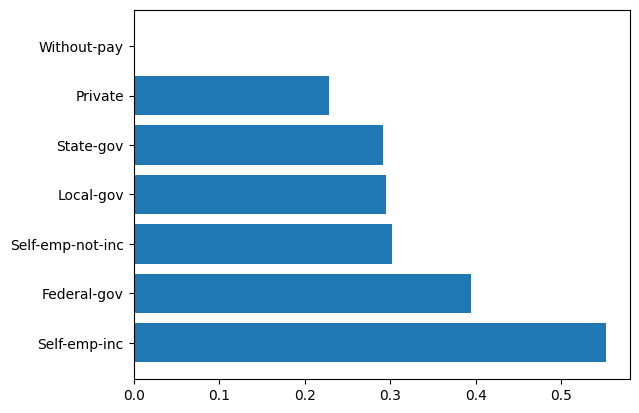

In [46]:
work_list = {}
for i in train['workclass'].unique():
    n = train.loc[(train['workclass'] == i) & (train['>50K,<=50K'] == 1)].shape[0] / \
    train.loc[(train['workclass'] == i)].shape[0]
    work_list[i] = n   

work_list = dict(sorted(work_list.items(), key=lambda item: item[1], reverse=True))
print(work_list)

fig, ax = plt.subplots()
y_pos = np.arange(len(work_list.keys()))
ax.barh(y_pos, work_list.values())
ax.set_yticks(y_pos, labels=work_list.keys())
plt.show()

{'Prof-school': 0.7704918032786885, 'Doctorate': 0.7672413793103449, 'Masters': 0.587037037037037, 'Bachelors': 0.43322475570032576, 'Assoc-voc': 0.2623762376237624, 'Assoc-acdm': 0.2229965156794425, 'Some-college': 0.20722057368941643, 'HS-grad': 0.17237903225806453, '7th-8th': 0.09090909090909091, '12th': 0.08333333333333333, '10th': 0.0778688524590164, '9th': 0.05405405405405406, '11th': 0.0473186119873817, '1st-4th': 0.044444444444444446, '5th-6th': 0.03571428571428571, 'Preschool': 0.0}


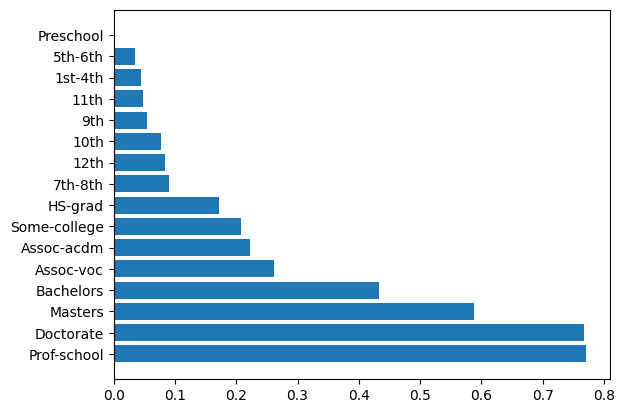

In [47]:
educ_list = {}
for i in train['education'].unique():
    n = train.loc[(train['education'] == i) & (train['>50K,<=50K'] == 1)].shape[0] / \
    train.loc[(train['education'] == i)].shape[0]
    educ_list[i] = n   


educ_list = dict(sorted(educ_list.items(), key=lambda item: item[1], reverse=True))
print(educ_list)

fig, ax = plt.subplots()
y_pos = np.arange(len(educ_list.keys()))
ax.barh(y_pos, educ_list.values())
ax.set_yticks(y_pos, labels=educ_list.keys())
plt.show()

{15: 0.7704918032786885, 16: 0.7672413793103449, 14: 0.587037037037037, 13: 0.43322475570032576, 11: 0.2623762376237624, 12: 0.2229965156794425, 10: 0.20722057368941643, 9: 0.17237903225806453, 4: 0.09090909090909091, 8: 0.08333333333333333, 6: 0.0778688524590164, 5: 0.05405405405405406, 7: 0.0473186119873817, 2: 0.044444444444444446, 3: 0.03571428571428571, 1: 0.0}


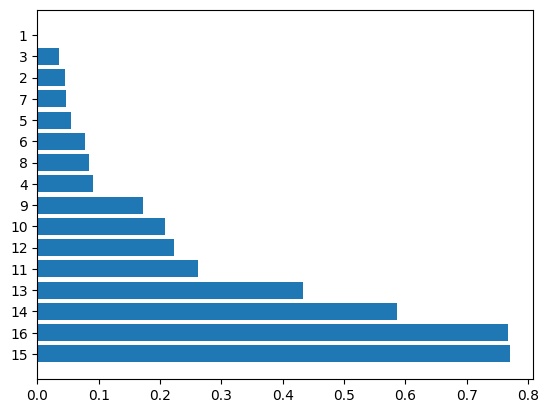

In [48]:
educ_n_list = {}
for i in train['education-num'].unique():
    n = train.loc[(train['education-num'] == i) & (train['>50K,<=50K'] == 1)].shape[0] / \
    train.loc[(train['education-num'] == i)].shape[0]
    educ_n_list[i] = n   
educ_n_list = dict(sorted(educ_n_list.items(), key=lambda item: item[1], reverse=True))
print(educ_n_list)

fig, ax = plt.subplots()
y_pos = np.arange(len(educ_n_list.keys()))
ax.barh(y_pos, educ_n_list.values())
ax.set_yticks(y_pos, labels=educ_n_list.keys())
plt.show()

{'Married-AF-spouse': 0.5, 'Married-civ-spouse': 0.4642857142857143, 'Married-spouse-absent': 0.11818181818181818, 'Divorced': 0.10471622701838529, 'Widowed': 0.08778625954198473, 'Separated': 0.06060606060606061, 'Never-married': 0.054842068726136756}


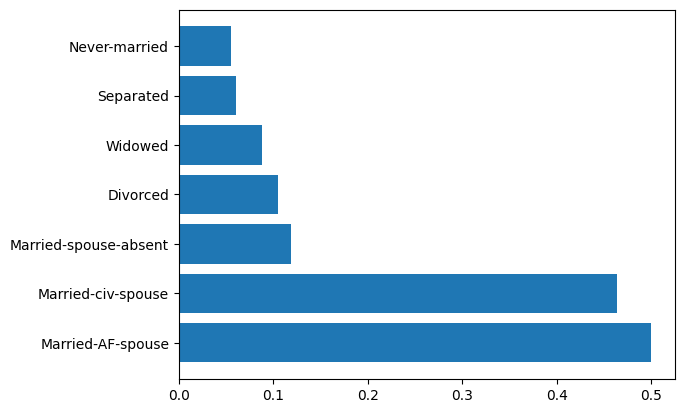

In [49]:
MS_list = {}
for i in train['marital-status'].unique():
    n = train.loc[(train['marital-status'] == i) & (train['>50K,<=50K'] == 1)].shape[0] / \
    train.loc[(train['marital-status'] == i)].shape[0]
    MS_list[i] = n   

MS_list = dict(sorted(MS_list.items(), key=lambda item: item[1], reverse=True))
print(MS_list)

fig, ax = plt.subplots()
y_pos = np.arange(len(MS_list.keys()))
ax.barh(y_pos, MS_list.values())
ax.set_yticks(y_pos, labels=MS_list.keys())
plt.show()

{'Exec-managerial': 0.501255230125523, 'Armed-Forces': 0.5, 'Prof-specialty': 0.46459824980111375, 'Protective-serv': 0.35714285714285715, 'Tech-support': 0.3037037037037037, 'Sales': 0.28351449275362317, 'Craft-repair': 0.24603174603174602, 'Transport-moving': 0.19750519750519752, 'Adm-clerical': 0.13693693693693693, 'Machine-op-inspct': 0.13333333333333333, 'Farming-fishing': 0.11552346570397112, 'Handlers-cleaners': 0.05263157894736842, 'Other-service': 0.04209445585215606, 'Priv-house-serv': 0.016129032258064516}


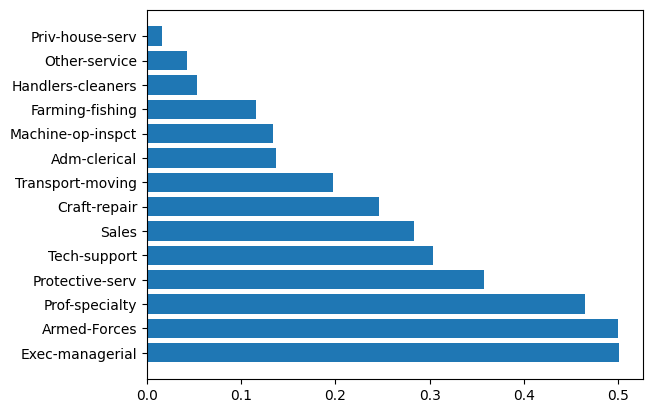

In [50]:
occupation_list = {}
for i in train['occupation'].unique():
    n = train.loc[(train['occupation'] == i) & (train['>50K,<=50K'] == 1)].shape[0] / \
    train.loc[(train['occupation'] == i)].shape[0]
    occupation_list[i] = n   

occupation_list = dict(sorted(occupation_list.items(), key=lambda item: item[1], reverse=True))
print(occupation_list)
#plt.barh(occupation_list.values(), occupation_list.keys())

fig, ax = plt.subplots()
y_pos = np.arange(len(occupation_list.keys()))
ax.barh(y_pos, occupation_list.values())
ax.set_yticks(y_pos, labels=occupation_list.keys())
plt.show()

{'Wife': 0.49676025917926564, 'Husband': 0.4664768314781258, 'Not-in-family': 0.11515151515151516, 'Unmarried': 0.06387434554973823, 'Other-relative': 0.04247104247104247, 'Own-child': 0.011843079200592153}


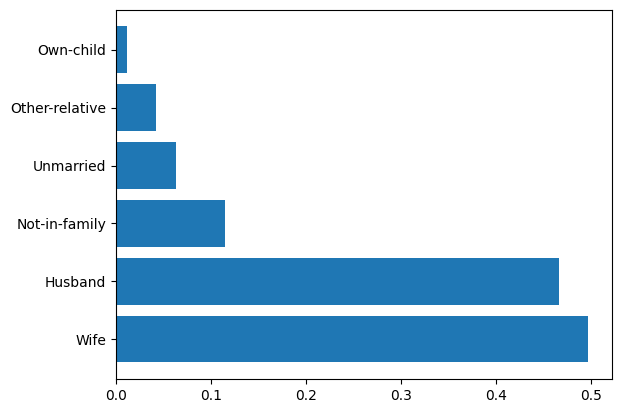

In [51]:
relationship_list = {}
for i in train['relationship'].unique():
    n = train.loc[(train['relationship'] == i) & (train['>50K,<=50K'] == 1)].shape[0] / \
    train.loc[(train['relationship'] == i)].shape[0]
    relationship_list[i] = n   

relationship_list = dict(sorted(relationship_list.items(), key=lambda item: item[1], reverse=True))
print(relationship_list)

fig, ax = plt.subplots()
y_pos = np.arange(len(relationship_list.keys()))
ax.barh(y_pos, relationship_list.values())
ax.set_yticks(y_pos, labels=relationship_list.keys())
plt.show()

{'White': 0.27699590583418626, 'Asian-Pac-Islander': 0.25838926174496646, 'Black': 0.13733905579399142, 'Amer-Indian-Eskimo': 0.10843373493975904, 'Other': 0.09722222222222222}


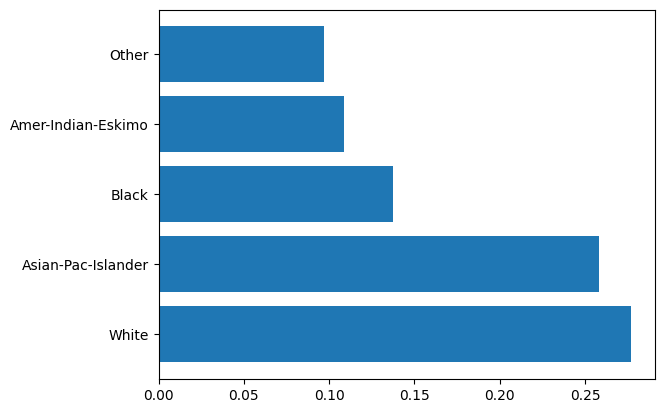

In [52]:
race_list = {}
for i in train['race'].unique():
    n = train.loc[(train['race'] == i) & (train['>50K,<=50K'] == 1)].shape[0] / \
    train.loc[(train['race'] == i)].shape[0]
    race_list[i] = n   

race_list = dict(sorted(race_list.items(), key=lambda item: item[1], reverse=True))
print(race_list)

fig, ax = plt.subplots()
y_pos = np.arange(len(race_list.keys()))
ax.barh(y_pos, race_list.values())
ax.set_yticks(y_pos, labels=race_list.keys())
plt.show()

При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? Какой из алгоритмов, на ваш взгляд окажется более качественным: логический или метрический? Почему?

<span style="color:orange">
Так как мы работаем с выборкой людей, есть наивное предположение, что она имеет кластерную структуру, так как люди склонны сбиваться в группы по интересам. Из этого предположения можно сделать вывод, что метрический алгоритм лучше. <br/>
Однако лучше обучить оба и посмотреть какой лучше.

## Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

<span style="color:orange">
    
## Вариант 1 
Преобразовать все катигориальные признаки посредствам обычного one-hot.

In [53]:
onehotencoder = OneHotEncoder(handle_unknown='error')

df_dencoder = pd.DataFrame(onehotencoder.fit_transform(df[['workclass', 'education', \
'marital-status', 'occupation', 'relationship', 'race']]).toarray())

encoded_columns_name = onehotencoder.get_feature_names_out(['workclass', 'education', \
'marital-status', 'occupation', 'relationship', 'race'])
dict_column_names = {}
for i in range(len(encoded_columns_name)):
    dict_column_names[i] = encoded_columns_name[i]
df_dencoder.rename(columns=dict_column_names, inplace=True)

df_enc = df.join(df_dencoder)
target = df_enc['>50K,<=50K']

df_enc.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', \
'>50K,<=50K'], axis= 1 , inplace= True)

In [54]:
#Визуализация Df 
#pd.set_option('display.max_rows', None)

#print(df_enc.loc[14001])
#print(df_enc)

#pd.reset_option('display.max_columns')
#pd.reset_option('display.max_rows')

<span style="color:orange">
Разбиваем на Train и Test с теми же индексами, что и в начале файла, для предотвращения утечки данных.


In [55]:
X_train = df_enc.iloc[ind_train]
X_test = df_enc.iloc[ind_test]
y_train = target.iloc[ind_train]
y_test = target.iloc[ind_test]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

<span style="color:orange">
И применим метод T-SNE для визуализации данных. Причём применим StandardScaler. <br/>
Интересен следующий вопрос:<br/>
Можно ли утвеждать, что данные разделились на классы, над которыми удобно строить KNN?<br/>
На данный момент отвечу на него утвердительно.

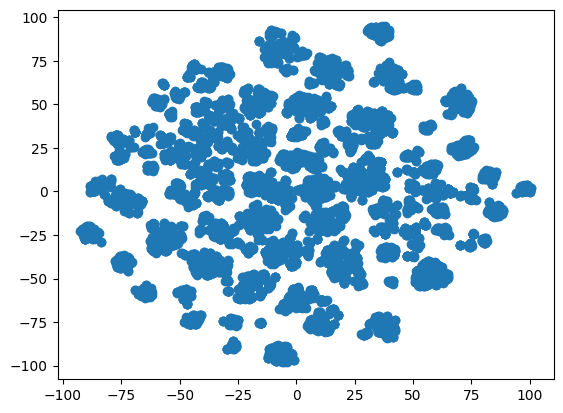

In [56]:
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_train_scaled)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

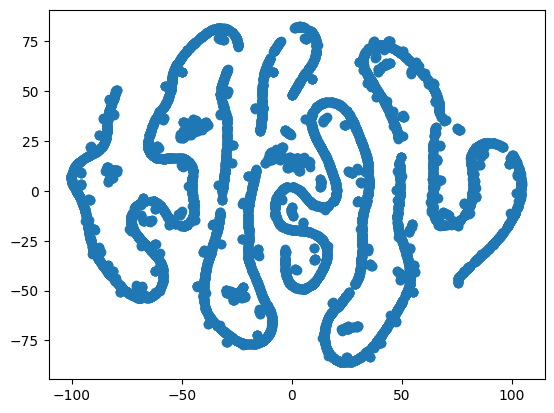

In [57]:
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_train)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

Для начала выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 
Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

<span style="color:orange">
Построение модели KNN на нешкалированных признаках

In [88]:
knn = KNeighborsClassifier()

F1_list = []
hyper_param_knn = {
'n_neighbors' : [1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 30, 45, 70]
}
clf = RandomizedSearchCV(knn, hyper_param_knn, cv=5, scoring = 'f1', return_train_score=True)
search = clf.fit(X_train, y_train)
b_par = search.best_params_
score_res = search.cv_results_

knn_best = KNeighborsClassifier(n_neighbors=b_par['n_neighbors'])
Model_best = knn_best.fit(X_train, y_train)
y_pred = Model_best.predict(X_test)

#for i in hyper_param_knn['n_neighbors']:
#    knn_best = KNeighborsClassifier(n_neighbors=i)
#    Model_best = knn_best.fit(X_train, y_train)
#    y_pred = Model_best.predict(X_test)
#    F1_list.append(f1_score(y_test, y_pred, labels = np.unique(target), average='micro'))


In [113]:
list_res = []
dict_res = {}
for i in range(len(score_res['params'])):
#    list_res.append(score_res['params'][i]['n_neighbors'])
    dict_res[score_res['params'][i]['n_neighbors']] = score_res['mean_test_score'][i]

print(dict_res)
#print(list_res)
#print(score_res['mean_test_score'])
#print(score_res['std_test_score'])

{9: 0.32164678725571616, 45: 0.15547591634707802, 6: 0.3105506927442213, 11: 0.29760457296332493, 13: 0.2863084838445025, 30: 0.2023049970403467, 10: 0.2817860562563819, 4: 0.3149677462655397, 70: 0.1060122607769773, 2: 0.32174899471464397}


{'n_neighbors': 2}
Accuracy_score: 0.7613302901858494
F1 micro: 0.7613302901858494
F1 macro: 0.5939899391051099


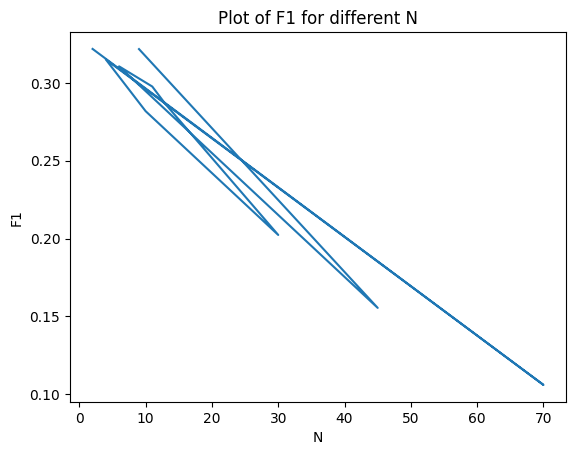

In [110]:
print(b_par)
Ac = accuracy_score(y_test, y_pred)
print('Accuracy_score:', Ac)
F1_1 = f1_score(y_test, y_pred, labels = np.unique(target), average='micro')
print('F1 micro:', F1_1)
F1_2 = f1_score(y_test, y_pred, labels = np.unique(target), average='macro')
print('F1 macro:', F1_2)


plt.plot(list_res, score_res['mean_test_score'])
plt.xlabel('N') #Подпись для оси х
plt.ylabel('F1') #Подпись для оси y
plt.title('Plot of F1 for different N') #Название
plt.show()

<span style="color:orange">
Построение модели KNN на шкалированных признаках

{'n_neighbors': 45}
Accuracy_score: 0.7510596674274536
F1 micro: 0.7510596674274536
F1 macro: 0.44503754636750203


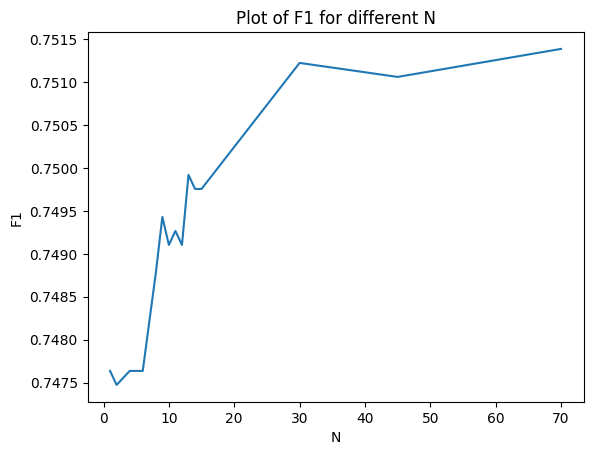

In [85]:
warnings.filterwarnings("ignore")
knn = KNeighborsClassifier()

F1_list = []
hyper_param_knn = {
'n_neighbors' : [1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 30, 45, 70]
}
clf = RandomizedSearchCV(knn, hyper_param_knn, cv=5)
search = clf.fit(X_train_scaled, y_train)
b_par = search.best_params_
print(b_par)


knn_best = KNeighborsClassifier(n_neighbors=b_par['n_neighbors'])
Model_best = knn_best.fit(X_train_scaled, y_train)
y_pred = Model_best.predict(X_test)

Ac = accuracy_score(y_test, y_pred)
print('Accuracy_score:', Ac)
F1_1 = f1_score(y_test, y_pred, labels = np.unique(target), average='micro')
print('F1 micro:', F1_1)
F1_2 = f1_score(y_test, y_pred, labels = np.unique(target), average='macro')
print('F1 macro:', F1_2)


for i in hyper_param_knn['n_neighbors']:
    knn_best = KNeighborsClassifier(n_neighbors=i)
    Model_best = knn_best.fit(X_train_scaled, y_train)
    y_pred = Model_best.predict(X_test)
    F1_list.append(f1_score(y_test, y_pred, labels = np.unique(target), average='micro'))


plt.plot(hyper_param_knn['n_neighbors'], F1_list)
plt.xlabel('N') #Подпись для оси х
plt.ylabel('F1') #Подпись для оси y
plt.title('Plot of F1 for different N') #Название
plt.show()

warnings.filterwarnings("default")

<span style="color:orange">
Построение модели Tree на нешкалированных признаках

In [69]:
tree = DecisionTreeClassifier(criterion='gini')

hyper_param_tree = {
'max_depth' : [1, 2, 4, 5, 6, 7, 8, 9, 10, 15]
}

clf = RandomizedSearchCV(tree, hyper_param_tree, cv=5)
search = clf.fit(X_train, y_train)
b_par = search.best_params_
print(b_par)

tree_best = DecisionTreeClassifier(criterion='gini', max_depth=b_par['max_depth'])
Model_best = tree_best.fit(X_train, y_train)
y_pred = Model_best.predict(X_test)

y_pred_proba = Model_best.predict_proba(X_test)

Ac = accuracy_score(y_test, y_pred)
print('Accuracy_score:',Ac)
F1_1 = f1_score(y_test, y_pred, labels = np.unique(target), average='micro')
print('F1 micro:', F1_1)
F1_2 = f1_score(y_test, y_pred, labels = np.unique(target), average='macro')
print('F1 macro:', F1_2)

{'max_depth': 7}
Accuracy_score: 0.8478969677209
F1 micro: 0.8478969677209
F1 macro: 0.7731526409699501


<span style="color:orange">
Построение модели Tree на шкалированных признаках

In [71]:
tree = DecisionTreeClassifier(criterion='gini')

hyper_param_tree = {
'max_depth' : [1, 2, 4, 6, 8, 10, 12, 14, 15, 20]
}

clf = RandomizedSearchCV(tree, hyper_param_tree, cv=5)
search = clf.fit(X_train_scaled, y_train)
b_par = search.best_params_
print(b_par)

tree_best = DecisionTreeClassifier(criterion='gini', max_depth=b_par['max_depth'])
Model_best = tree_best.fit(X_train_scaled, y_train)
y_pred = Model_best.predict(X_test_scaled)

y_pred_proba = Model_best.predict_proba(X_test)

Ac = accuracy_score(y_test, y_pred)
print('Accuracy_score:',Ac)
F1_1 = f1_score(y_test, y_pred, labels = np.unique(target), average='micro')
print('F1 micro:', F1_1)
F1_2 = f1_score(y_test, y_pred, labels = np.unique(target), average='macro')
print('F1 macro:', F1_2)

{'max_depth': 6}
Accuracy_score: 0.8430061949788067
F1 micro: 0.8430061949788067
F1 macro: 0.7681761170823553


/home/mikle/ML/Girafe/env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

In [62]:
# your code here

## Обучение классификаторов на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

In [63]:
# your code here

## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Есть ли изменения динамики среднего значения качества по кросс-валидации алгоритма? Объясните почему?

In [ ]:
# your code here

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [ ]:
# your code here

<span style="color:orange">
    
## Вариант 2 ##
Наложим некоторые эмпирические предположения на выборку (Условный экспертный анализ)<br/>
Пройдёмся по каждому из признаков по отдельности. Основная информация приведена сврху. <br/>
    
#### Age ####
Менять не обязательно. Можно использовать Standard scaler. <br/>

#### Workclass ####
Рабочий класс. Считаю необходимым привести к числовому виду. <br/>
А именно кластеризация в 4 столбца:<br/>
    
1) Люди связанные с госслужбой<br/>
    None = 0<br/>
    Local-gov = 1<br/>
    State-gov = 2<br/>
    Federal-gov = 3<br/>
В данном столбце идёт распределение по значимости человека. Чем выше он по иерархии, тем больше у него значение.<br/>
Если же человек не пренадлежит к госслужбе - значение 0.<br/>
    
2) Люди не связанные с госслужбой<br/>
    None = 0<br/>
    Self-emp-not-inc = 1<br/>
    Self-emp-inc = 2<br/>
Распределение по Incorporated Self Employment и Unincorporated Self Employment взято из статьи:<br/>
https://smallbiztrends.com/2013/11/incorporated-versus-unincorporated-self-employment.html<br/>
Оснавная гипотиза стоящая за этим столбцом - что распределение Private нам не понятно, смысла в нём нет. <br/>

3) Private или нет<br/>
   None = 0<br/>
   Private = 1<br/>

4) Without-pay или нет<br/>
   None = 0<br/>
   Without-pay = 1<br/>

#### Fnlwgt ####
Вообще не понял описание, сколько не читал. Засуну в StandardScaller и посмотрим<br/>

#### Education ####
Образованность того или иного человека.

1) 1st-4th <br/>
2) 5th-6th <br/>
3) 7th-8th<br/>
4) 9th <br/>
5) 10th<br/>
6) 11th<br/>
7) 12th<br/>
8) Bachelors<br/>
9) Masters<br/>
10) Doctorate<br/>

#### Education-num ####

#### Marital-status ####

#### Occupation #### 

#### Relationship #### 

#### Race #### 

#### Capital-gain #### 

#### Capital-loss #### 

#### Hours-per-week #### 

#### >50K,<=50K #### 